Classes: 5 | Total samples: 3670


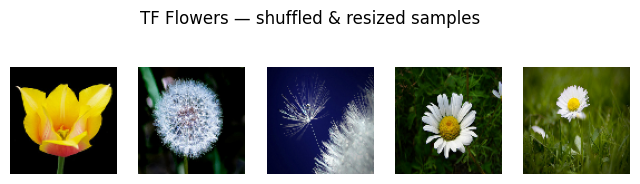

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

# Config
IMG_SIZE = 96  # small & fast

# Load TF Flowers
ds, info = tfds.load('tf_flowers', split='train', with_info=True, as_supervised=True)
num_classes = info.features['label'].num_classes
print("Classes:", num_classes, "| Total samples:", info.splits['train'].num_examples)

# Build arrays safely: resize each image BEFORE stacking
X_list, y_list = [], []
for img, label in tfds.as_numpy(ds):
    img = img.astype(np.float32) / 255.0                    # [0,1]
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy() # make shape uniform
    X_list.append(img)
    y_list.append(label)

X = np.stack(X_list)                 # shape (N, 96, 96, 3)
y = np.array(y_list, dtype=np.int32) # shape (N,)

# Shuffle
rng = np.random.default_rng(42)
perm = rng.permutation(len(X))
X, y = X[perm], y[perm]

# Preview
plt.figure(figsize=(8,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i])
    plt.axis("off")
plt.suptitle("TF Flowers — shuffled & resized samples", y=1.05)
plt.show()


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
input_shape = (IMG_SIZE, IMG_SIZE, 3)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2202, 96, 96, 3) Test: (1468, 96, 96, 3)


In [29]:
inputs = keras.Input(shape=input_shape)
x = inputs  # already normalized

# Block 1
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
# Block 2
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
# Block 3 (Grad-CAM target)
x = layers.Conv2D(128, 3, activation="relu", padding="same", name="last_conv")(x)
# Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [30]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=25, batch_size=32,
    callbacks=[es],
    verbose=1
)

train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc  = model.evaluate(X_test,  y_test,  verbose=0)[1]
print(f"Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")


Epoch 1/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3169 - loss: 1.4845 - val_accuracy: 0.3988 - val_loss: 1.3034
Epoch 2/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4388 - loss: 1.2758 - val_accuracy: 0.4562 - val_loss: 1.2457
Epoch 3/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4623 - loss: 1.2207 - val_accuracy: 0.4834 - val_loss: 1.1835
Epoch 4/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4810 - loss: 1.1747 - val_accuracy: 0.5015 - val_loss: 1.1582
Epoch 5/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5142 - loss: 1.1313 - val_accuracy: 0.5196 - val_loss: 1.1382
Epoch 6/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5387 - loss: 1.1001 - val_accuracy: 0.5287 - val_loss: 1.0944
Epoch 7/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5559 - loss: 1.0521 - val_accuracy: 0.6224 - val_loss: 0.9931
Epoch 8/25
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5810 - loss: 1.0104 - val_accuracy: 0.6254 - v

In [31]:
def grad_cam(model, img, layer_name="last_conv"):
    """
    img: single RGB image, shape (H,W,3)
    returns: (heatmap[H,W], predicted_class)
    """
    img_batch = np.expand_dims(img, axis=0).astype("float32")
    conv_layer = model.get_layer(layer_name)
    grad_model = keras.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch)
        class_idx = tf.argmax(preds[0])
        class_score = preds[:, class_idx]

    grads = tape.gradient(class_score, conv_out)
    weights = tf.reduce_mean(grads, axis=(1,2))
    cam = tf.reduce_sum(weights[:, None, None, :] * conv_out, axis=-1)
    cam = tf.squeeze(cam)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    cam_resized = tf.image.resize(cam[..., None], (IMG_SIZE, IMG_SIZE)).numpy()[...,0]
    return cam_resized, int(class_idx.numpy())


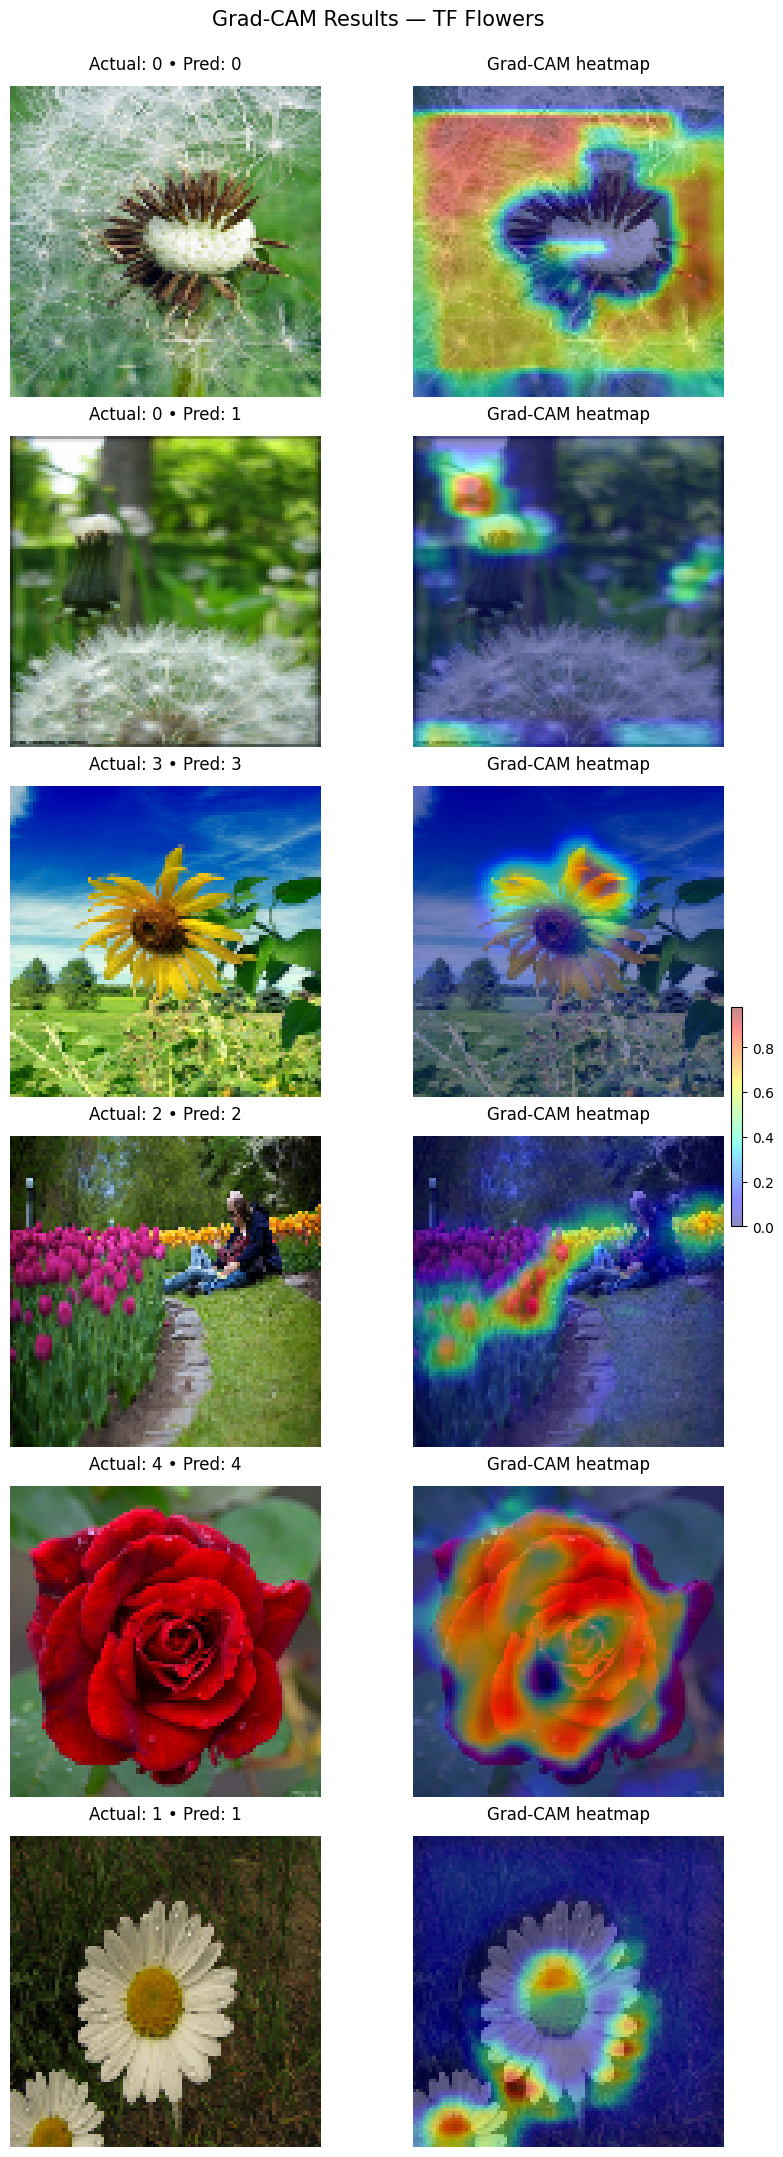

In [33]:
indices = [0, 3, 7, 20, 30, 31]
n = len(indices)

fig, axs = plt.subplots(n, 2, figsize=(8, 3.5 * n), constrained_layout=True)

for r, i in enumerate(indices):
    img = X_test[i]
    gt = y_test[i]
    pred = np.argmax(model.predict(img[None, ...], verbose=0))
    cam, _ = grad_cam(model, img, "last_conv")

    # Left: original
    ax = axs[r, 0] if n > 1 else axs[0]
    ax.imshow(img)
    ax.set_title(f"Actual: {gt} • Pred: {pred}", fontsize=12, pad=12)  # ↑ add more pad
    ax.axis("off")

    # Right: Grad-CAM overlay
    axh = axs[r, 1] if n > 1 else axs[1]
    axh.imshow(img)
    hm = axh.imshow(cam, cmap="jet", alpha=0.45)
    axh.set_title("Grad-CAM heatmap", fontsize=12, pad=12)  # ↑ add more pad
    axh.axis("off")

# Shared colorbar
fig.colorbar(hm, ax=axs[:, 1] if n > 1 else axs[1], fraction=0.03, pad=0.02)
fig.suptitle("Grad-CAM Results — TF Flowers", fontsize=15, y=1.02)
plt.show()
